## Analytic Assignment 1

### Phase 1: Supercell vs. Competition

In the first phase of the analysis we are looking to understand  how is Supercell doing vs. King and Zynga. By answering the below questions, we would set the scene on which we can build the analysis further:

a)  What is the average monthly  user growth  rates of Supercell, King and Zynga?

b)  What is the net reach of Supercell, King and Zynga in the sample for each of the 3 months?

c)  What is the total time spent per month  per user for Supercell, King and Zynga for July?

d)  Which of Supercell, King and Zynga had the largest average session duration in June?

e)  What is the gender distribution of Supercell vs. King users?

In [1]:
import os.path
import datetime
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
# set data path
data_path = os.path.join(os.path.dirname('__file__'), "Verto_Data_Analyst_Assignment/Assignment_1_Data/")

In [3]:
# import data files to pandas dataframes
demographics_df = pd.read_csv(data_path + "demographics_data.csv", sep=';')
devices_df = pd.read_csv(data_path + "devices_data.csv", sep=';')
dictionary_df = pd.read_csv(data_path + "dictionary_data.csv", sep=';')
main_branches_df = pd.read_csv(data_path + "main_branches.csv", sep=';')
sessions_df = pd.read_csv(data_path + "sessions_data.csv", sep=';')
subjects_tree_df = pd.read_csv(data_path + "subjects_tree_data.csv", sep=';')

#### a)  What is the average monthly user growth rates of Supercell, King and Zynga?

To answer this question, get the monthly users number in May and July, then calculate the monthly growth rates in two months. July = May * (1 + n)^2

In [4]:
# There are 177 rows that subject_id are actually branch_id, so firstly modify branch_id to subject_id.

subjects_id_sessions_df = sessions_df[~sessions_df['subject_id'].isin(subjects_tree_df['branch_id'])]
branches_id_sessions_df = sessions_df[sessions_df['subject_id'].isin(subjects_tree_df['branch_id'])]
branches_id_sessions_df = branches_id_sessions_df.rename(columns = {'subject_id':'branch_id'})

id_modification_df = pd.merge(branches_id_sessions_df, subjects_tree_df, on='branch_id', how='left')
id_modification_df.drop(['readable_name', 'parent_branch_id', 'ancestors_branch_ids'],inplace=True,axis=1)
id_modification_df = id_modification_df.drop_duplicates(subset =['branch_id', 'start_timestamp'], keep='last')
id_modification_df.drop(['branch_id'],inplace=True,axis=1)

In [5]:
# get the new dataframe user_growth_rates_df with corrected subject_id.

user_growth_rates_df = pd.concat([subjects_id_sessions_df, id_modification_df])
user_growth_rates_df.reset_index(inplace=True, drop=True)
user_growth_rates_df.head()

,device_id,end_timestamp,interaction_type,os,start_timestamp,subject_id,user_id
0,10212,2016-07-02 05:35:36,app,android,2016-07-02 05:29:24,5245226,2694
1,10212,2016-07-19 13:33:20,app,android,2016-07-19 13:30:27,5245226,2694
2,10212,2016-06-26 19:13:03,app,android,2016-06-26 19:10:29,5245226,2694
3,10212,2016-05-18 02:03:57,app,android,2016-05-18 01:51:42,5245226,2694
4,10212,2016-06-23 05:06:51,app,android,2016-06-23 05:02:43,5245226,2694


In [6]:
# set property column in main_branches_df to lowercase
main_branches_df['property'] = main_branches_df['property'].str.lower()

# rename readable_name column in dictionary_df to match with main_branches_df
dictionary_df = dictionary_df.rename(columns = {'readable_name':'property'})
dictionary_df['property'] = dictionary_df['property'].str.lower()

# merge dictionary_df and main_branches_df 
dictionary_df = pd.merge(dictionary_df, main_branches_df, on='property', how='left')
dictionary_df.drop(['branch_id'],inplace=True,axis=1)

# categorize property in dictionary_df to parent company name
dictionary_df.ix[dictionary_df['property'].str.startswith('facebook'), 'company_name'] = "Facebook"
dictionary_df.ix[dictionary_df['property'].str.startswith('fb'), 'company_name'] = "Facebook"
dictionary_df.ix[dictionary_df['property'].str.startswith('amazon'), 'company_name'] = "Amazon"
dictionary_df.ix[dictionary_df['property'].str.startswith('lovefilm'), 'company_name'] = "Amazon"
dictionary_df.ix[dictionary_df['property'].str.startswith('youtube'), 'company_name'] = "Google"
dictionary_df.ix[dictionary_df['property'].str.startswith('walmart'), 'company_name'] = "Walmart"
dictionary_df.ix[dictionary_df['property'].str.startswith('wal-mart'), 'company_name'] = "Walmart"
dictionary_df.ix[dictionary_df['property'].str.startswith('words with friends'), 'company_name'] = "Zynga"
dictionary_df['company_name'].unique()

array(['Facebook', 'Amazon', 'Google', 'Zynga', 'Walmart', 'Supercell',
       'King'], dtype=object)

In [7]:
# merge user_growth_rates_df and dictionary_df to get company name for each session

user_growth_rates_df = pd.merge(user_growth_rates_df, dictionary_df, on='subject_id', how='left')
user_growth_rates_df.head()

,device_id,end_timestamp,interaction_type,os,start_timestamp,subject_id,user_id,property,company_name
0,10212,2016-07-02 05:35:36,app,android,2016-07-02 05:29:24,5245226,2694,youtube,Google
1,10212,2016-07-19 13:33:20,app,android,2016-07-19 13:30:27,5245226,2694,youtube,Google
2,10212,2016-06-26 19:13:03,app,android,2016-06-26 19:10:29,5245226,2694,youtube,Google
3,10212,2016-05-18 02:03:57,app,android,2016-05-18 01:51:42,5245226,2694,youtube,Google
4,10212,2016-06-23 05:06:51,app,android,2016-06-23 05:02:43,5245226,2694,youtube,Google


In [8]:
# normalize the timestamp and add month column to dataframe

user_growth_rates_df['start_timestamp'] = pd.to_datetime(user_growth_rates_df['start_timestamp'])
user_growth_rates_df['end_timestamp'] = pd.to_datetime(user_growth_rates_df['end_timestamp'])
user_growth_rates_df['month'] = user_growth_rates_df['start_timestamp'].map(lambda x: x.month)
user_growth_rates_df.head()

,device_id,end_timestamp,interaction_type,os,start_timestamp,subject_id,user_id,property,company_name,month
0,10212,2016-07-02 05:35:36,app,android,2016-07-02 05:29:24,5245226,2694,youtube,Google,7
1,10212,2016-07-19 13:33:20,app,android,2016-07-19 13:30:27,5245226,2694,youtube,Google,7
2,10212,2016-06-26 19:13:03,app,android,2016-06-26 19:10:29,5245226,2694,youtube,Google,6
3,10212,2016-05-18 02:03:57,app,android,2016-05-18 01:51:42,5245226,2694,youtube,Google,5
4,10212,2016-06-23 05:06:51,app,android,2016-06-23 05:02:43,5245226,2694,youtube,Google,6


In [9]:
# get the users number for each company in each month

user_growth_rates_df.groupby(['company_name', 'month']).user_id.nunique()

company_name  month
Amazon        5         89
              6         79
              7         87
Facebook      5        100
              6        100
              7         99
Google        5         97
              6         95
              7         95
King          5         33
              6         36
              7         36
Supercell     5         19
              6         17
              7         18
Walmart       5         63
              6         57
              7         54
Zynga         5         28
              6         30
              7         29
Name: user_id, dtype: int64

In [10]:
# (users number in July) = (users number in May) * (1 + monthly growth rate)^2
# (monthly growth rate) = sqrt((users number in July) / (users number in May)) - 1

King_growth_rate = math.sqrt(36/33) - 1
Supercell_growth_rate = math.sqrt(18/19) - 1
Zynga_growth_rate = math.sqrt(29/28) - 1

print('Average monthly user growth rates of Supercell: ', '{:.3f}'.format(Supercell_growth_rate))
print('Average monthly user growth rates of King: ', '{:.3f}'.format(King_growth_rate))
print('Average monthly user growth rates of Zynga: ', '{:.3f}'.format(Zynga_growth_rate))

Average monthly user growth rates of Supercell:  -0.027
Average monthly user growth rates of King:  0.044
Average monthly user growth rates of Zynga:  0.018


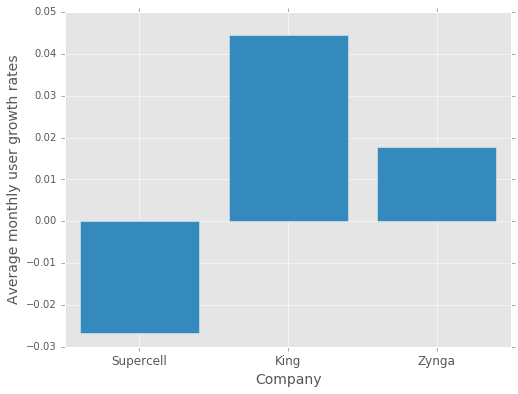

In [11]:
# To plot the monthly growth rate for each company with matplotlib

plt.figure(figsize=(8,6)) # set a new figure
x = range(3)

user_growth_rates_bar = plt.bar(x, list([Supercell_growth_rate, King_growth_rate, Zynga_growth_rate]), align='center') # bar plot all the values
plt.xticks(x, ['Supercell', 'King', 'Zynga'], fontsize=12) # set xticks by company name
# plt.ylim(-0.1, 0.1) # set ylim to mark annotation later
plt.xlabel('Company', fontsize=14)
plt.ylabel('Average monthly user growth rates', fontsize=14)

#### b) What is the net reach of Supercell, King and Zynga in the sample for each of the 3 months?

To bulid dataframe, then calculate the net reach for each one in each month

In [12]:
# net reach for King
king_df = user_growth_rates_df[user_growth_rates_df['company_name']=='King']
king_df = pd.DataFrame(king_df.groupby(['month']).user_id.unique())
king_net_reach_may = 33
king_net_reach_june = king_net_reach_may + 36 - len(set(king_df.ix[5][0]) & set(king_df.ix[6][0]))
king_net_reach_july = king_net_reach_june + 36 - len(set(king_df.ix[6][0]) & set(king_df.ix[7][0]))

print('Net reach of King in May is: ', king_net_reach_may)
print('Net reach of King in June is: ', king_net_reach_june)
print('Net reach of King in July is: ', king_net_reach_july)

Net reach of King in May is:  33
Net reach of King in June is:  37
Net reach of King in July is:  39


In [13]:
# net reach for Supercell
supercell_df = user_growth_rates_df[user_growth_rates_df['company_name']=='Supercell']
supercell_df = pd.DataFrame(supercell_df.groupby(['month']).user_id.unique())
supercell_net_reach_may = 19
supercell_net_reach_june = supercell_net_reach_may + 17 - len(set(supercell_df.ix[5][0]) & set(supercell_df.ix[6][0]))
supercell_net_reach_july = supercell_net_reach_june + 18 - len(set(supercell_df.ix[6][0]) & set(supercell_df.ix[7][0]))

print('Net reach of Supercell in May is: ', supercell_net_reach_may)
print('Net reach of Supercell in June is: ', supercell_net_reach_june)
print('Net reach of Supercell in July is: ', supercell_net_reach_july)

Net reach of Supercell in May is:  19
Net reach of Supercell in June is:  20
Net reach of Supercell in July is:  21


In [14]:
# net reach for Zynga
zynga_df = user_growth_rates_df[user_growth_rates_df['company_name']=='Zynga']
zynga_df = pd.DataFrame(zynga_df.groupby(['month']).user_id.unique())
zynga_net_reach_may = 28
zynga_net_reach_june = zynga_net_reach_may + 30 - len(set(zynga_df.ix[5][0]) & set(zynga_df.ix[6][0]))
zynga_net_reach_july = zynga_net_reach_june + 29 - len(set(zynga_df.ix[6][0]) & set(zynga_df.ix[7][0]))

print('Net reach of Zynga in May is: ', zynga_net_reach_may)
print('Net reach of Zynga in June is: ', zynga_net_reach_june)
print('Net reach of Zynga in July is: ', zynga_net_reach_july)

Net reach of Zynga in May is:  28
Net reach of Zynga in June is:  31
Net reach of Zynga in July is:  34


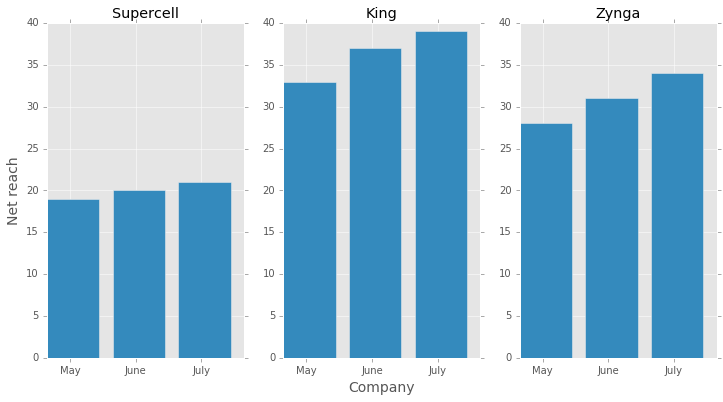

In [15]:
# To plot with matplotlib

ind = np.arange(3)  # the x locations for the groups
width = 0.35       # the width of the bars

fig = plt.figure(figsize=(12,6)) # set a new figure

ax1 = fig.add_subplot(131)
ax1.bar(ind,[19, 20, 21])
ax1.set_title('Supercell')
ax1.set_ylim([0, 40]) # set ylim to mark annotation later
ax1.set_xticks(ind + width)
ax1.set_xticklabels(['May', 'June', 'July'])
ax1.set_ylabel('Net reach', fontsize=14)

ax2 = fig.add_subplot(132)
ax2.bar(ind,[33, 37, 39])
ax2.set_title('King')
ax2.set_ylim([0, 40]) # set ylim to mark annotation later
ax2.set_xticks(ind + width)
ax2.set_xticklabels(['May', 'June', 'July'])
ax2.set_xlabel('Company', fontsize=14)

ax3 = fig.add_subplot(133)
ax3.bar(ind,[28, 31, 34])
ax3.set_title('Zynga')
ax3.set_ylim([0, 40]) # set ylim to mark annotation later
ax3.set_xticks(ind + width)
ax3.set_xticklabels(['May', 'June', 'July'])

#### c) What is the total time spent per month per user for Supercell, King and Zynga for July?

To calculate the sum of time sessions for each company, then divided by user number in July.

In [16]:
# get the sessions duration and sums

user_growth_rates_df['duration'] = (user_growth_rates_df['end_timestamp'] - user_growth_rates_df['start_timestamp']).astype('timedelta64[m]')
user_growth_rates_df.groupby(['company_name', 'month']).duration.sum()

company_name  month
Amazon        5         39145.0
              6         35955.0
              7         32936.0
Facebook      5        656900.0
              6        687815.0
              7        691026.0
Google        5        258387.0
              6        254084.0
              7        255790.0
King          5        158520.0
              6        132718.0
              7        154668.0
Supercell     5         46873.0
              6         42948.0
              7         49130.0
Walmart       5         13093.0
              6         10339.0
              7          8233.0
Zynga         5         54898.0
              6         58276.0
              7         56731.0
Name: duration, dtype: float64

In [17]:
# total time spent per person = (session sum)(m) / 60 / (users number in July)

king_time_july = 154668 / 60 / 36
supercell_time_july = 49130 / 60 / 18
zynga_time_july = 56731 / 60 / 29

print('Total time spent per month per user for Supercell, King and Zynga are: \
{:.2f}, {:.2f} and {:.2f} hours, respectively.'.format(supercell_time_july, king_time_july, zynga_time_july))

Total time spent per month per user for Supercell, King and Zynga are: 45.49, 71.61 and 32.60 hours, respectively.


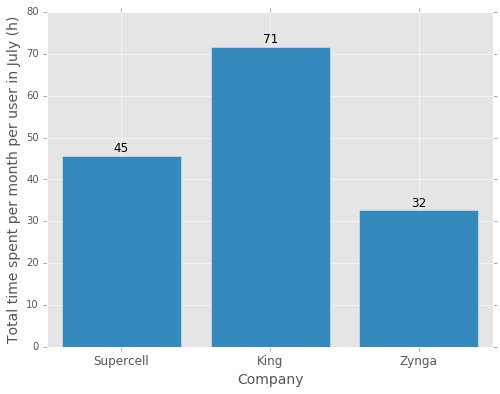

In [18]:
plt.figure(figsize=(8,6)) # set a new figure
x = range(3)

time_spent_bar = plt.bar(x, list([supercell_time_july, king_time_july, zynga_time_july]), align='center') # bar plot all the values
plt.xticks(x, ['Supercell', 'King', 'Zynga'], fontsize=12) # set xticks by company name
# plt.ylim(-0.1, 0.1) # set ylim to mark annotation later
plt.xlabel('Company', fontsize=14)
plt.ylabel('Total time spent per month per user in July (h)', fontsize=14)

# To set a method for labeling the exact number on the bar chart
def autolabel(rects):
    # attach some annotation labels
    for rect in rects:
        height = int(rect.get_height())
        plt.annotate(height, 
                (rect.get_x() + rect.get_width() / 2., height), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                fontsize=12,
                textcoords='offset points')

autolabel(time_spent_bar) # lable the current bar chart

#### d) Which of Supercell, King and Zynga had the largest average session duration in June?

(average session duration) = (sum session duration) / (sessions number)

In [19]:
# get sessions number in each month
user_growth_rates_df.groupby(['company_name', 'month']).duration.size()

company_name  month
Amazon        5         2981
              6         2922
              7         2918
Facebook      5        31020
              6        30733
              7        30996
Google        5         4593
              6         4575
              7         4599
King          5         2987
              6         2926
              7         2925
Supercell     5         1820
              6         1768
              7         1868
Walmart       5          652
              6          625
              7          618
Zynga         5         3384
              6         3487
              7         3530
dtype: int64

In [20]:
# (average session duration) = (sum session duration) / (sessions number)

king_average_duration_june = 132718 / 2926
supercell_average_duration_june = 42948 / 1768
zynga_average_duration_june = 58276 / 3487

print('Average session duration for Supercell, King and Zynga in June are: \
{:.2f}, {:.2f} and {:.2f} minutes, respectively.'.format(supercell_average_duration_june, \
king_average_duration_june, zynga_average_duration_june))
print('So King had the largest average session duration in June.')

Average session duration for Supercell, King and Zynga in June are: 24.29, 45.36 and 16.71 minutes, respectively.
So King had the largest average session duration in June.


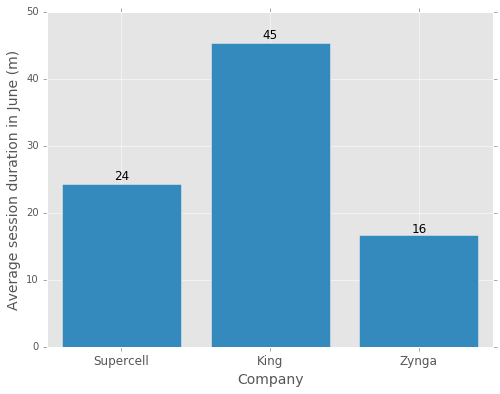

In [21]:
plt.figure(figsize=(8,6)) # set a new figure
x = range(3)

average_session_duration_bar = plt.bar(x, list([supercell_average_duration_june, king_average_duration_june, zynga_average_duration_june]), align='center') # bar plot all the values
plt.xticks(x, ['Supercell', 'King', 'Zynga'], fontsize=12) # set xticks by company name
# plt.ylim(-0.1, 0.1) # set ylim to mark annotation later
plt.xlabel('Company', fontsize=14)
plt.ylabel('Average session duration in June (m)', fontsize=14)

autolabel(average_session_duration_bar) # lable the current bar chart

#### e) What is the gender distribution of Supercell vs. King users?

In [22]:
# merge user_growth_rates_df with demographics information
user_growth_rates_df = pd.merge(user_growth_rates_df, demographics_df, on='user_id', how='left')

# show gender distribution for each company
user_growth_rates_df.groupby(['company_name', 'gender']).user_id.nunique()

company_name  gender
Amazon        1         52
              2         43
Facebook      1         55
              2         45
Google        1         54
              2         45
King          1         17
              2         22
Supercell     1         14
              2          6
Walmart       1         39
              2         33
Zynga         1         18
              2         16
Name: user_id, dtype: int64

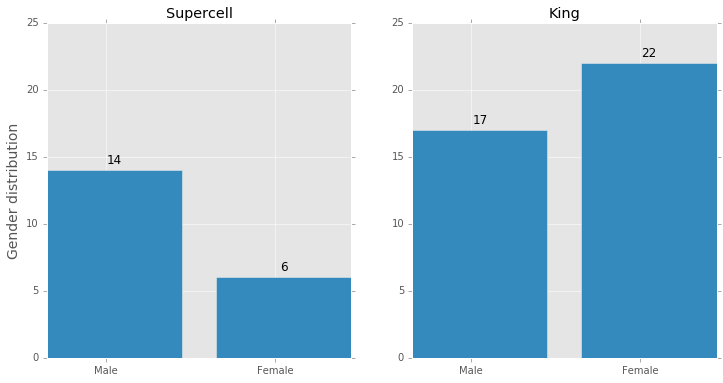

In [23]:
# To plot with matplotlib

ind = np.arange(2)  # the x locations for the groups
width = 0.35       # the width of the bars

fig = plt.figure(figsize=(12,6)) # set a new figure

ax1 = fig.add_subplot(121)
supercell_gender_bar = ax1.bar(ind,[14, 6])
ax1.set_title('Supercell')
ax1.set_ylim([0, 25]) # set ylim to mark annotation later
ax1.set_xticks(ind + width)
ax1.set_xticklabels(['Male', 'Female'])
ax1.set_ylabel('Gender distribution', fontsize=14)
autolabel(supercell_gender_bar)

ax2 = fig.add_subplot(122)
king_gender_bar = ax2.bar(ind,[17, 22])
ax2.set_title('King')
ax2.set_ylim([0, 25]) # set ylim to mark annotation later
ax2.set_xticks(ind + width)
ax2.set_xticklabels(['Male', 'Female'])
autolabel(king_gender_bar)

### Phase 2: Clash of Clans vs. Candy Crush Saga

#### a)  What’s the reach of Clash of Clans among Candy Crush Saga users?

Get the user_id for Candy Crush Saga users, then check how many users are aslo Clash of Clans users.

In [24]:
# get the dateframe for Clash of Clans and Candy Crush Saga users
candy_df = user_growth_rates_df[user_growth_rates_df['property'].isin(['candy crush saga'])]
candy_users = list(candy_df['user_id'].unique())
candy_users_number = len(candy_users)
candy_user_df = user_growth_rates_df[user_growth_rates_df['user_id'].isin(candy_users)]

clash_df = candy_user_df[candy_user_df['property'].isin(['clash of clans'])]
clash_users = list(clash_df['user_id'].unique())
clash_users_number = len(clash_users)

In [25]:
print('The reach of Clash of Clans among Candy Crush Saga users is {:.2f}%.'.format(clash_users_number/candy_users_number*100))

The reach of Clash of Clans among Candy Crush Saga users is 10.71%.


#### b)  What’s the reach of Candy Crush Saga among users aged 35 or above? How does this compare to Clash of Clans?

In [26]:
# get users aged 35 or above df
aged_35_or_above_df = user_growth_rates_df[user_growth_rates_df['age'] >= 35]
aged_35_or_above_number = aged_35_or_above_df['user_id'].nunique()

# get candy users aged 35 or above
candy_35_df = aged_35_or_above_df[aged_35_or_above_df['property'].isin(['candy crush saga'])]
candy_35_number = candy_35_df['user_id'].nunique()

# get clash users aged 35 or above
clash_35_df = aged_35_or_above_df[aged_35_or_above_df['property'].isin(['clash of clans'])]
clash_35_number = clash_35_df['user_id'].nunique()

In [27]:
print('The reach of Clash of Clans and Candy Crush Saga users that among aged 35 or above are {:.2f}% and {:.2f}%.'\
.format(clash_35_number/aged_35_or_above_number*100, candy_35_number/aged_35_or_above_number*100))

The reach of Clash of Clans and Candy Crush Saga users that among aged 35 or above are 14.47% and 28.95%.


#### c)  How many users play Candy Crush Saga on Tablets?

In [28]:
# merge candy_df and devices dataframe

candy_crush_saga_devices_df = pd.merge(candy_df, devices_df, on='device_id', how='left')
candy_crush_saga_devices_df.groupby(['device_type']).user_id_x.nunique()

device_type
Smartphone    21
Tablet         7
Name: user_id_x, dtype: int64

In [29]:
print('There are 7 users playing Candy Crush Saga on Tablets.')

There are 7 users playing Candy Crush Saga on Tablets.


#### d)  What’s the deduplicated net reach of Clash of Clans and Candy Crush Saga combined? 

I am not quite sure about the concept of deduplicated net reach. I know what net reach and dulications are. So I calculated the duplications here.

In [30]:
# get duplications for candy

candy_df = pd.DataFrame(candy_df.groupby(['month']).user_id.unique())

# calculate the duplications in June and July
candy_deduplicated_net_reach = len(set(candy_df.ix[5][0]) & set(candy_df.ix[6][0])) + \
len(set(candy_df.ix[6][0]) & set(candy_df.ix[7][0]))

print(candy_deduplicated_net_reach)

47


In [31]:
# get duplications for clash

clash_df = user_growth_rates_df[user_growth_rates_df['property']=='clash of clans']
clash_df = pd.DataFrame(clash_df.groupby(['month']).user_id.unique())

# calculate the duplications in June and July
clash_deduplicated_net_reach = len(set(clash_df.ix[5][0]) & set(clash_df.ix[6][0])) + \
len(set(clash_df.ix[6][0]) & set(clash_df.ix[7][0]))

print(clash_deduplicated_net_reach)

24


In [32]:
# combine the 2 duplications
print('There are {} deduplicated net reach of Clash of Clans and Candy Crush Saga combined.'.format(\
candy_deduplicated_net_reach+ clash_deduplicated_net_reach))

There are 71 deduplicated net reach of Clash of Clans and Candy Crush Saga combined.


### Phase 3: Advertising Channels

#### a)  What’s the reach of each of YouTube, Facebook, Amazon  and Walmart among King and Zynga gamers who are not Supercell gamers? 

Filter the King and Zynga gamers who are not Supercell gamers first, then calculate the reach of each of YouTube, Facebook, Amazon  and Walmart

In [33]:
# Filter the non supercell_user
supercell_user_df = user_growth_rates_df[user_growth_rates_df['company_name'].isin(['Supercell'])]
supercell_users = list(supercell_user_df['user_id'].unique())
non_supercell_user_df = user_growth_rates_df[~user_growth_rates_df['user_id'].isin(supercell_users)]

# in non supercell_user, filter the king_and_zynga_user
king_and_zynga_user_df = non_supercell_user_df[non_supercell_user_df['company_name'].isin(['King', 'Zynga'])]
king_and_zynga_user_users = list(king_and_zynga_user_df['user_id'].unique())
king_and_zynga_no_supercell_user_df = user_growth_rates_df[user_growth_rates_df['user_id'].isin(king_and_zynga_user_users)]
king_and_zynga_no_supercell_user_number = king_and_zynga_no_supercell_user_df.user_id.nunique()
king_and_zynga_no_supercell_user_df.groupby('company_name').user_id.nunique()

company_name
Amazon      56
Facebook    59
Google      58
King        34
Walmart     44
Zynga       33
Name: user_id, dtype: int64

In [34]:
print('The reach of YouTube, Facebook, Amazon and Walmart among King and Zynga gamers who are not Supercell gamers are: {:.2f}%, {:.2f}%, {:.2f}% and {:.2f}%.'\
.format(58/king_and_zynga_no_supercell_user_number*100, 59/king_and_zynga_no_supercell_user_number*100, 56/king_and_zynga_no_supercell_user_number*100, 44/king_and_zynga_no_supercell_user_number*100))

The reach of YouTube, Facebook, Amazon and Walmart among King and Zynga gamers who are not Supercell gamers are: 98.31%, 100.00%, 94.92% and 74.58%.


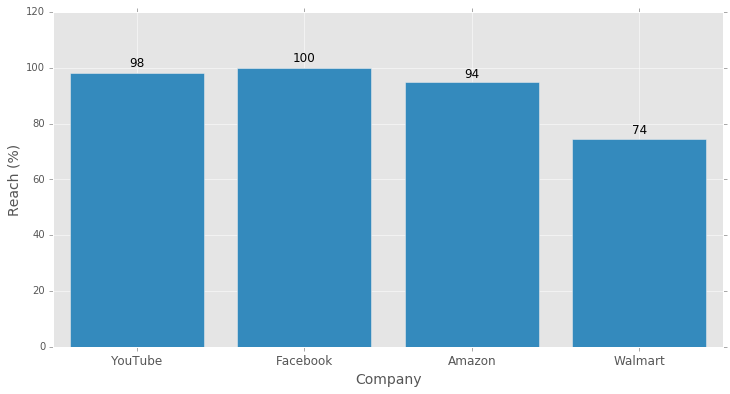

In [35]:
plt.figure(figsize=(12,6)) # set a new figure
x = range(4)

reach_bar = plt.bar(x, list([58/king_and_zynga_no_supercell_user_number*100, 59/king_and_zynga_no_supercell_user_number*100, 56/king_and_zynga_no_supercell_user_number*100, 44/king_and_zynga_no_supercell_user_number*100]), align='center') # bar plot all the values
plt.xticks(x, ['YouTube', 'Facebook', 'Amazon', 'Walmart'], fontsize=12) # set xticks by company name
plt.ylim(0, 120) # set ylim to mark annotation later
plt.xlabel('Company', fontsize=14)
plt.ylabel('Reach (%)', fontsize=14)

autolabel(reach_bar) # lable the current bar chart

#### b)  What is Facebook’s average number of sessions per active user per month among Clash of Clan players? And what is it among Candy Crush Saga users? 

For all Clash of Clan players, get their session related to Facebook first, than get Facebook active user number in these users.

In [36]:
# filter all clash users sessions out
clash_user_session_df = user_growth_rates_df[user_growth_rates_df['property'].isin(['clash of clans'])]
clash_users = list(clash_user_session_df['user_id'].unique())
clash_user_df = user_growth_rates_df[user_growth_rates_df['user_id'].isin(clash_users)]

# filter all candy users sessions out
candy_user_session_df = user_growth_rates_df[user_growth_rates_df['property'].isin(['candy crush saga'])]
candy_users = list(candy_user_session_df['user_id'].unique())
candy_user_df = user_growth_rates_df[user_growth_rates_df['user_id'].isin(candy_users)]

In [37]:
# in clash users sessions, filter all Facebook sessions out
# (average number of sessions) = (all Facebook sessions) / (Facebook users number) / (month number)
clash_facebook_sessions = len(clash_user_df[clash_user_df['company_name']=='Facebook'])
clash_facebook_users = clash_user_df[clash_user_df['company_name']=='Facebook'].user_id.nunique()
clash_average_facebook_number = clash_facebook_sessions / clash_facebook_users / 3

candy_facebook_sessions = len(candy_user_df[candy_user_df['company_name']=='Facebook'])
candy_facebook_users = candy_user_df[candy_user_df['company_name']=='Facebook'].user_id.nunique()
candy_average_facebook_number = candy_facebook_sessions / candy_facebook_users / 3

print("Facebook’s average number of sessions per active user per month among Clash of Clan players and Candy Crush Saga users are: {:.1f} and {:.1f}, respectlvely."\
.format(clash_average_facebook_number, candy_average_facebook_number))

Facebook’s average number of sessions per active user per month among Clash of Clan players and Candy Crush Saga users are: 233.3 and 362.6, respectlvely.


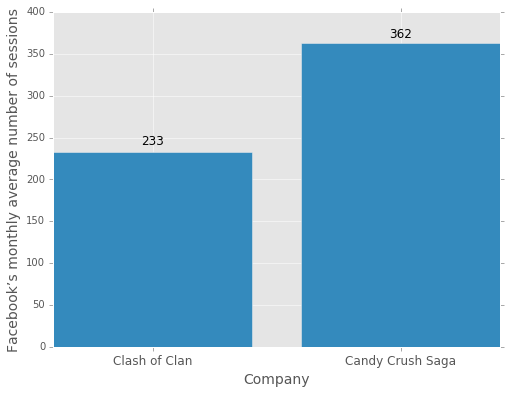

In [38]:
plt.figure(figsize=(8,6)) # set a new figure
x = range(2)

session_bar = plt.bar(x, list([clash_average_facebook_number, candy_average_facebook_number]), align='center') # bar plot all the values
plt.xticks(x, ['Clash of Clan', 'Candy Crush Saga'], fontsize=12) # set xticks by company name
# plt.ylim(0, 120) # set ylim to mark annotation later
plt.xlabel('Company', fontsize=14)
plt.ylabel('Facebook’s monthly average number of sessions', fontsize=14)

autolabel(session_bar) # lable the current bar chart